In [210]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import FastText
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Flatten, Dropout, Bidirectional
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")

In [61]:
sns.set(rc={'figure.figsize':(7,5)})

In [62]:
# we import and take a look at the dataset
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [63]:
# we check for nulls
df.isna().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

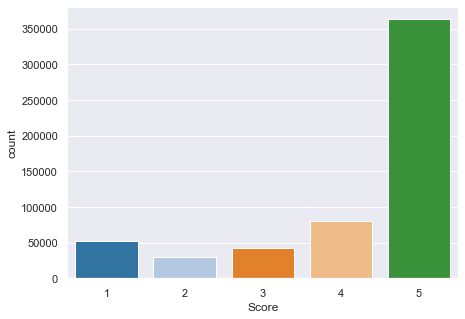

In [64]:
sns.countplot(df["Score"], palette="tab20"); # distribution of Ratings

We see that we have a negatively skewed distribution with a very high number of positive reviews. We will try to balance these going forward.

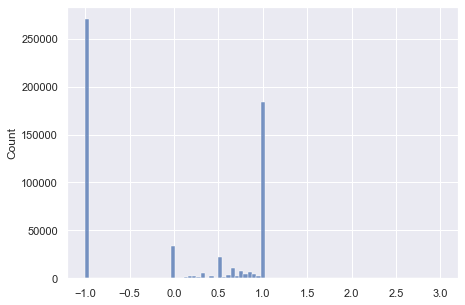

In [65]:
help_not_help_ratio = np.where(df['HelpfulnessDenominator'] > 0, df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'], -1)
sns.histplot(help_not_help_ratio);

Without delving too deep into the details of the dataset, we will drop the irrelevant columns and start preprocessing for our model.

In [66]:
df = df[(df["Score"] == 5) | (df["Score"] == 1)] # we keep only 1 and 5 star reviews to create sentiment model

In [67]:
df["Score"] = df["Score"].apply(lambda x: 1 if x == 5 else 0) # create label 1 as positive 0 as negative

In [68]:
df["Text"] = df["Summary"] + [" "] + df["Text"]
# concatenate summary and text as both helps model

In [69]:
df = df[["Text", "Score"]] # drop irrelevant columns

In [70]:
df.head()

,Text,Score
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
4,Great taffy Great taffy at a great price. The...,1
6,Great! Just as good as the expensive brands! ...,1
7,"Wonderful, tasty taffy This taffy is so good. ...",1


In [73]:
df.duplicated().sum() # we check for duplicate reviews

127281

We see that we have a lot of duplicates. We will drop them.

In [74]:
df.drop_duplicates(keep="first", inplace=True)

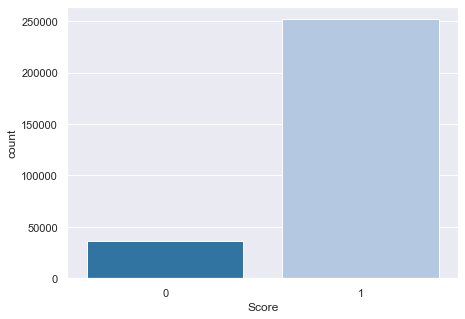

In [76]:
sns.countplot(df["Score"], palette="tab20"); # distribution of target label

We see that its heavily imbalanced. We will downsample to balance our dataset.

In [85]:
np.random.RandomState(45)
neg_rev_count = (df["Score"] == 0).sum()
sub_df = df[df["Score"] == 1].sample(neg_rev_count)
df = pd.concat([sub_df, df[df["Score"] == 0]]).sample(frac=1).reset_index(drop=True)
df.head()

,Text,Score
0,Bad Cheese The cheese was old and hard tried t...,0
1,Voss Bottled Water I think anybody who buys bo...,0
2,Can somebody say way too SOUR My son makes a f...,0
3,Me Tastes great and definitely an eye opener! ...,1
4,Not what I call demerara Very disappointed Th...,0


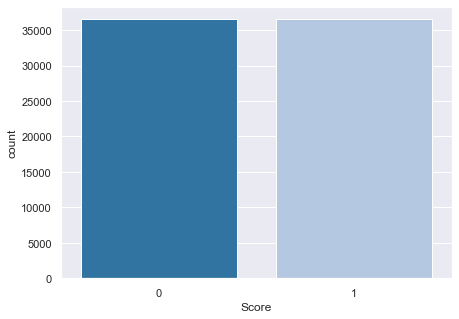

In [86]:
sns.countplot(df["Score"], palette="tab20"); # distribution of target label

We will use simple_preprocess from gensim. Lets see what it does first.

In [88]:
dummy_sentence = "WOW!!! I LOVED IT!!!!! The product was awesome!! :D"

In [89]:
simple_preprocess(dummy_sentence)

['wow', 'loved', 'it', 'the', 'product', 'was', 'awesome']

Lets apply to entire dataset.

In [90]:
df["Text"] = [simple_preprocess(line, deacc=True) for line in df['Text']]
df.head()

,Text,Score
0,"[bad, cheese, the, cheese, was, old, and, hard...",0
1,"[voss, bottled, water, think, anybody, who, bu...",0
2,"[can, somebody, say, way, too, sour, my, son, ...",0
3,"[me, tastes, great, and, definitely, an, eye, ...",1
4,"[not, what, call, demerara, very, disappointed...",0


**We will not be removing the stopwords because since we are using Fasttext, we want to build the context.**

For eg.(We dont want this to happen):
- Product not good -> product good
- Product good -> product good

In [92]:
porter_stemmer = PorterStemmer()
df["Text"] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['Text']] # we do stemming
df.head()

,Text,Score
0,"[bad, chees, the, chees, wa, old, and, hard, t...",0
1,"[voss, bottl, water, think, anybodi, who, bui,...",0
2,"[can, somebodi, sai, wai, too, sour, my, son, ...",0
3,"[me, tast, great, and, definit, an, ey, open, ...",1
4,"[not, what, call, demerara, veri, disappoint, ...",0


In [95]:
X_train, X_test, y_train, y_test = train_test_split(df["Text"], df["Score"], test_size=0.2)

In [99]:
ft = FastText(vector_size=200, window=5, min_count=1, workers=6)
ft.build_vocab(X_train) # we keep unseen set separate
ft.train(X_train, total_examples=ft.corpus_count, epochs=20)
print(ft.vector_size)

200


In [102]:
tokenizer = Tokenizer(oov_token="<OOV>") # initilize tokenizer
tokenizer.fit_on_texts(X_train)

In [110]:
{k: tokenizer.word_index[k] for k in list(tokenizer.word_index)[:10]} # first 10 words

{'<OOV>': 1,
 'the': 2,
 'and': 3,
 'it': 4,
 'to': 5,
 'of': 6,
 'thi': 7,
 'is': 8,
 'br': 9,
 'in': 10}

In [111]:
total_words = len(tokenizer.word_index)
total_words

33056

In [115]:
df["Text"].apply(lambda x: len(x)).mean() # average count of words per review

77.95945760854677

In [118]:
max_len = 150 # we keep 150 just to be safe
train_sequence = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequence, maxlen=max_len)

Lets try to understand with an example

In [157]:
X_train[X_train.apply(lambda x: len(x)) == 8][38776]

['tea', 'great', 'tast', 'better', 'imho', 'that', 'earl', 'grai']

In [148]:
pd.Series(train_sequence)[(pd.Series(train_sequence)).apply(lambda x: len(x)) == 8]

24650    [46, 39, 22, 109, 4165, 13, 1251, 3056]
dtype: object

In [166]:
tokenizer.word_index["tea"], tokenizer.word_index["great"], tokenizer.word_index["grai"]

(46, 39, 3056)

In [167]:
train_padded[24650]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   46,
         39,   22,  109, 4165,   13, 1251, 3056])

Lets preprocess our test set too and keep for validation.

In [168]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

In [169]:
# create zero matrix of shape of our Fasttext embedding
embedding_matrix_ft = np.zeros((total_words, ft.vector_size))

In [179]:
list(tokenizer.word_index.items())[:5]

[('<OOV>', 1), ('the', 2), ('and', 3), ('it', 4), ('to', 5)]

In [170]:
missed = 0 # add miss counter to debug
for word,i in tokenizer.word_index.items():
    try:
        embedding_matrix_ft[i] = ft.wv[word] # fill the embedding matrix
    except:
        missed += 1

In [184]:
# initialize Bi-LSTM RNN model
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=ft.vector_size, input_length=max_len, weights=[embedding_matrix_ft], trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

# compile model
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [185]:
# train_model
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test)) 

Epoch 1/10
1826/1826 [==============================] - 48s 19ms/step - loss: 0.2522 - accuracy: 0.8992 - val_loss: 0.1830 - val_accuracy: 0.9301
Epoch 2/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.1628 - accuracy: 0.9385 - val_loss: 0.1560 - val_accuracy: 0.9404
Epoch 3/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.1333 - accuracy: 0.9508 - val_loss: 0.1491 - val_accuracy: 0.9458
Epoch 4/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.1127 - accuracy: 0.9586 - val_loss: 0.1620 - val_accuracy: 0.9440
Epoch 5/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.0958 - accuracy: 0.9656 - val_loss: 0.1930 - val_accuracy: 0.9403
Epoch 6/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.0789 - accuracy: 0.9709 - val_loss: 0.1742 - val_accuracy: 0.9405
Epoch 7/10
1826/1826 [==============================] - 33s 18ms/step - loss: 0.0676 - accuracy: 0.9756 - val_loss: 0.1808 -

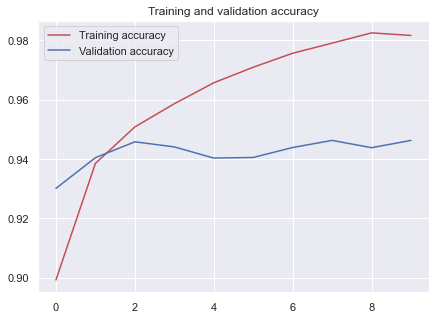

In [188]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0);

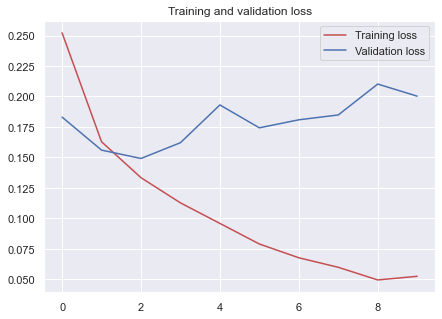

In [190]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0);

In [192]:
# accuracy score
pred = np.round(model.predict(test_padded))
accuracy_score(y_test, pred)

0.9462402410628681

In [193]:
# roc auc score
roc_auc_score(y_test, pred)

0.946237636333511

In [194]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7306
           1       0.95      0.94      0.95      7296

    accuracy                           0.95     14602
   macro avg       0.95      0.95      0.95     14602
weighted avg       0.95      0.95      0.95     14602



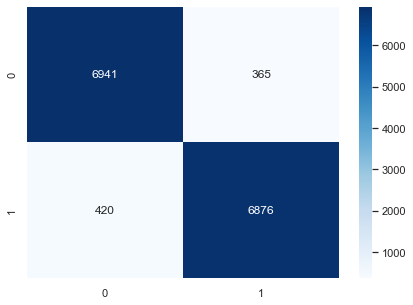

In [200]:
# confusion matrix
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt="d", cmap="Blues");

In [201]:
# a test function to get sentiment for any sentence
def get_sentiment(sentence):
    sentence = simple_preprocess(sentence, deacc=True)
    sentence = [[porter_stemmer.stem(word) for word in sentence]]
    input_sequence = tokenizer.texts_to_sequences(sentence)
    input_padded = pad_sequences(input_sequence, maxlen=max_len)
    pred = np.round(model.predict(input_padded))
    if pred == 1:
        return "Positive"
    else:
        return "Negative"

In [206]:
user_input = """California is a great state to live in, I just love it!!! 
                Not only it is very large, but there are many people who live in the city. 
                We can also find different types of jobs around the city."""

In [207]:
get_sentiment(user_input)

'Positive'

In [208]:
user_input2 = """This is the worst place to live in, I hate it!!! 
                Not only it is very stinky, but there are no places to eat also. 
                We cannot also find any type of jobs here."""

In [209]:
get_sentiment(user_input2)

'Negative'

We see that our model is pretty accurate. We will save the model and neccessary objects and use it for our API.

In [211]:
model.save("sentiment_model.h5")

In [212]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)
    f.close()